# Анализ рынка общественного питания Москвы

**Заказчик**: инвесторы фонда «Shut Up and Take My Money».

**Цель проекта**: провести исследование рынка общественного питания Москвы, найти интересные особенности и презентовать полученные результаты, которые в будущем помогут инвесторам в выборе подходящего места.

**Входные данные**: датасет с заведениями общественного питания Москвы, составленный на основе данных сервисов Яндекс.Карты и Яндекс.Бизнес на лето 2022 года. Информация, размещённая в сервисе Яндекс.Бизнес, могла быть добавлена пользователями или найдена в общедоступных источниках. Она носит исключительно справочный характер.

**План работы**:

 **1.** Загрузка и предобработка данных;
 
 **2.** Исследовательский анализ данных (посмотрим, как обстоят дела с распределением категорий заведений, с ценовыми диапазонами, узнаем, чем отличаются распределения показателей в зависимости от географии);
 
 **3.** Отдельно изучим категорию "кофейни" и дадим заказчикам исследования рекомендации.


**Описание данных**:

 - **name** — название заведения;
 - **address** — адрес заведения;
 - **category** — категория заведения, например «кафе», «пиццерия» или «кофейня»;
 - **hours** — информация о днях и часах работы;
 - **lat** — широта географической точки, в которой находится заведение;
 - **lng** — долгота географической точки, в которой находится заведение;
 - **rating** — рейтинг заведения по оценкам пользователей в Яндекс Картах (высшая оценка — 5.0);
 - **price** — категория цен в заведении, например «средние», «ниже среднего», «выше среднего» и так далее;
 - **avg_bill** — строка, которая хранит среднюю стоимость заказа в виде диапазона, например:
     -  «Средний счёт: 1000–1500 ₽»;
     - «Цена чашки капучино: 130–220 ₽»;
     - «Цена бокала пива: 400–600 ₽»...

 - **middle_avg_bill** — число с оценкой среднего чека, которое указано только для значений из столбца avg_bill, начинающихся с подстроки «Средний счёт»:
     - Если в строке указан ценовой диапазон из двух значений, в столбец войдёт медиана этих двух значений;
     - Если в строке указано одно число — цена без диапазона, то в столбец войдёт это число;
     - Если значения нет или оно не начинается с подстроки «Средний счёт», то в столбец ничего не войдёт.
     
 - **middle_coffee_cup** — число с оценкой одной чашки капучино, которое указано только для значений из столбца avg_bill, начинающихся с подстроки «Цена одной чашки капучино»:
     - Если в строке указан ценовой диапазон из двух значений, в столбец войдёт медиана этих двух значений;
     - Если в строке указано одно число — цена без диапазона, то в столбец войдёт это число;
     - Если значения нет или оно не начинается с подстроки «Цена одной чашки капучино», то в столбец ничего не войдёт.
     
 - **chain** — число, выраженное 0 или 1, которое показывает, является ли заведение сетевым (для маленьких сетей могут встречаться ошибки):
     - 0 — заведение не является сетевым;
     - 1 — заведение является сетевым.
 - **district** — административный район, в котором находится заведение, например Центральный административный округ;
 - **seats** — количество посадочных мест.

## Предобработка данных

### Загрузка данных, вывод общей информации о датасетах

Подключаем библиотеки:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import json
from plotly import graph_objects as go
from folium import Map, Marker, Choropleth
from folium.plugins import MarkerCluster

color = '\u001b[35m' # задаем ANSI-код, чтобы можно было выделить текст цветом
back = '\033[0m' # задаем код для обозначения места прекращения выделения теста цветом

Загрузим файлы и ознакомимся с данными:

In [2]:
try:
    data = pd.read_csv('moscow_places.csv')
except FileNotFoundError:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/moscow_places.csv')
except Exception:
    print("Some other exception")  

Функция для первичного изучения датафреймов:

In [3]:
def information_about_df (df: pd.DataFrame, limit_na_category: int = 10 ) -> None:
    print('Вывод шапки таблицы:')
    display(df.head())
    print('-'*40)
    print('Вывод общей информации:')
    print('')
    print(df.info())
    print('-'*40)
    print('Количество пропусков в данных:')
    print('')
    count = 0
    shape_0 = df.shape[0]
    for element in df.columns:
        if df[element].isna().sum()>0:
            print(element, ' - ', df[element].isna().sum(), 'пропусков, ', round(df[element].isna().sum()*100 / shape_0,2), '% от числа строк.')
            count = +1
        if count == 0:
            print(element,'- пропусков НЕТ')   
    print('-'*40)
    print('Количество дубликатов в данных:')
    print('')
    if df.duplicated().sum() >0:
        print('Дубликатов:', df.duplicated().sum())
    else:
        print('Дубликатов НЕ найдено')

In [4]:
information_about_df(data)

Вывод шапки таблицы:


,name,category,address,district,hours,lat,lng,rating,price,avg_bill,middle_avg_bill,middle_coffee_cup,chain,seats
0,WoWфли,кафе,"Москва, улица Дыбенко, 7/1",Северный административный округ,"ежедневно, 10:00–22:00",55.878494,37.478860,5.0,NaN,NaN,NaN,NaN,0,NaN
1,Четыре комнаты,ресторан,"Москва, улица Дыбенко, 36, корп. 1",Северный административный округ,"ежедневно, 10:00–22:00",55.875801,37.484479,4.5,выше среднего,Средний счёт:1500–1600 ₽,1550.0,NaN,0,4.0
2,Хазри,кафе,"Москва, Клязьминская улица, 15",Северный административный округ,"пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...",55.889146,37.525901,4.6,средние,Средний счёт:от 1000 ₽,1000.0,NaN,0,45.0
3,Dormouse Coffee Shop,кофейня,"Москва, улица Маршала Федоренко, 12",Северный административный округ,"ежедневно, 09:00–22:00",55.881608,37.488860,5.0,NaN,Цена чашки капучино:155–185 ₽,NaN,170.0,0,NaN
4,Иль Марко,пиццерия,"Москва, Правобережная улица, 1Б",Северный административный округ,"ежедневно, 10:00–22:00",55.881166,37.449357,5.0,средние,Средний счёт:400–600 ₽,500.0,NaN,1,148.0


----------------------------------------
Вывод общей информации:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8406 entries, 0 to 8405
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               8406 non-null   object 
 1   category           8406 non-null   object 
 2   address            8406 non-null   object 
 3   district           8406 non-null   object 
 4   hours              7870 non-null   object 
 5   lat                8406 non-null   float64
 6   lng                8406 non-null   float64
 7   rating             8406 non-null   float64
 8   price              3315 non-null   object 
 9   avg_bill           3816 non-null   object 
 10  middle_avg_bill    3149 non-null   float64
 11  middle_coffee_cup  535 non-null    float64
 12  chain              8406 non-null   int64  
 13  seats              4795 non-null   float64
dtypes: float64(6), int64(1), object(7)
memory usage: 919.5

Явных дубликатов нет, но есть пропуски, далее нужно будет решить, что с ними делать.

### Дубликаты, аномалии

Проверим значения колонок файлов на скрытые дубликаты и аномалии:

In [5]:
# функция для вывода уникальных значений столбцов:
def unique_values (df: pd.DataFrame):
     for element in df.columns:
            print('')
            print(element, ':')
            print('')
            print(df[element].sort_values().unique())

In [6]:
unique_values(data)


name :

['#КешбэкКафе' '+39 Pizzeria Mozzarella bar' '1 Этаж' ... 'Ясно' 'Яуза'
 'ночной Баку']

category :

['бар,паб' 'булочная' 'быстрое питание' 'кафе' 'кофейня' 'пиццерия'
 'ресторан' 'столовая']

address :

['Москва, 1-й Автозаводский проезд, 5'
 'Москва, 1-й Балтийский переулок, 3/25'
 'Москва, 1-й Варшавский проезд, 1Ас9' ...
 'Москва, шоссе Энтузиастов, 86А, корп. 3' 'Москва, шоссе Энтузиастов, с2'
 'Москва, № 7']

district :

['Восточный административный округ' 'Западный административный округ'
 'Северный административный округ'
 'Северо-Восточный административный округ'
 'Северо-Западный административный округ'
 'Центральный административный округ'
 'Юго-Восточный административный округ'
 'Юго-Западный административный округ' 'Южный административный округ']

hours :

['Нет информации'
 'вт 08:30–17:00; ср,чт 12:00–20:30; пт 08:30–17:00; сб 09:00–16:30'
 'вт 13:00–21:00; ср 11:00–20:00; чт 13:00–21:00; пт-вс 11:00–20:00' ...
 'чт круглосуточно, перерыв 10:00–20:00; сб кругло

На первый взгляд с данными все в порядке. 

Посмотрим **колонку 'name'** поподробнее:

In [7]:
sorted(data['name'].unique())

['#КешбэкКафе',
 '+39 Pizzeria Mozzarella bar',
 '1 Этаж',
 '1-я Креветочная',
 '10 Идеальных Пицц',
 '1001 Ночь',
 '100ловая',
 '100лоффка',
 '13',
 '13 Chef doner',
 '15 Kitchen+Bar',
 '15-й Шар',
 '16 Июня',
 '16 Тонн',
 '18 Грамм',
 '1901 Comfort Food Zone',
 '1у',
 '2 Типа',
 '2-й Этаж',
 '2046',
 '21 Век',
 '22 Акра Кофе&Хлеб',
 '2U-Ту-Ю',
 '3 Ступени',
 '351 Bar',
 '4 Сезона',
 '4.2. Bar',
 '4/1 Restaurant',
 '42 Coffee Shop',
 '47',
 '495',
 '4friends Coffee',
 '4tuna Cafe&Grill',
 '5 Stars Coffee',
 '55.709201, 37.392257',
 '6 Am Bread Kitchen',
 '6 Рукопожатий',
 '69 раков',
 '7 Сэндвичей',
 '7 элемент',
 '7/12',
 '8 Oz',
 '8 Вафель',
 '8 Зёрен',
 '8 Пончиков',
 '800°с Contemporary Steak',
 '8bit Pizza',
 '9 Bar Coffe',
 '9 Bar Coffee',
 '9 Зёрен',
 'A-cafe',
 'ABC Coffee Roasters',
 'ABC coffee roasters',
 'Acai Family',
 'Accent',
 "Adam's Chicken",
 'Adria Mare',
 'Ahava',
 'Air Coffee',
 'Al Halal',
 'Al33 Пиццерия бар Боттега',
 'All Day',
 'Alma',
 'Alternative coffee',

**При беглой проверке названий, есть подозрение в неявных дубликатах**:

 - 'ABC Coffee Roasters' и 'ABC coffee roasters';
    
 - 'Bb Grill' и 'Bb grill';
 
 - 'Bổ' и 'Bổ';
 
 - 'Deli2Go' и 'Deli2go'; 
 
 - 'Di Villaggio' и 'Di villaggio';
 
 - 'Festa & Тесто' и 'Festa&Тесто';
 
 - 'Free & Со' и 'Free&co';
 
 - 'Ho Cho Pho' и 'Ho Chu Pho';
 
 - 'Istanbul Kebab' и 'Istanbul kebab';
 
 - "It's СоТ - Кофейня" и "It's СоТ-Кофейня";
 
 - 'Ku: Рамен Изакая бар' и 'Ku: рамен изакая бар';
 
 - 'Korean Chick' и'Korean chick'.
 
 
 Но, если рассмотреть строки с этими данными из датасета, то видно, что даже, если допущена ошибка в написании, удалить мы эти данные не можем, так как адреса этих мест разные. Например:

In [8]:
data[data['name'] == 'Istanbul Kebab']

,name,category,address,district,hours,lat,lng,rating,price,avg_bill,middle_avg_bill,middle_coffee_cup,chain,seats
1985,Istanbul Kebab,быстрое питание,"Москва, Ленинградский проспект, 62, стр. 26",Северный административный округ,"ежедневно, 09:00–23:00",55.800601,37.533053,4.4,средние,NaN,NaN,NaN,0,NaN


In [9]:
data[data['name'] == 'Istanbul kebab']

,name,category,address,district,hours,lat,lng,rating,price,avg_bill,middle_avg_bill,middle_coffee_cup,chain,seats
3999,Istanbul kebab,ресторан,"Москва, улица Тимура Фрунзе, 11, стр. 13",Центральный административный округ,"ежедневно, 10:00–22:00",55.734805,37.588245,4.7,NaN,NaN,NaN,NaN,0,160.0


Адреса разные, районы разные. Оставляем эти данные.

Приведем колонки с адресом и названиями к нижнему регистру и проверим наличие неявных дубликатов из их числа:

In [10]:
data['name'] = data['name'].str.lower()
data['address'] = data['address'].str.lower()
double = data[data.duplicated(subset=['name', 'address'])]
print('Количество неявных дубликатов:', color, len(double))

Количество неявных дубликатов:  4


4 штуки. Удаляем их:

In [11]:
data = data.drop(labels = [215,1511,2420,3109],axis = 0)

### Пропуски

**Количество пропусков в данных, обнаруженных в прошлом шаге**:

 - name - пропусков НЕТ
 - category - пропусков НЕТ
 - address - пропусков НЕТ
 - district - пропусков НЕТ
 - hours  -  536 пропусков,  6.38 % от числа строк.
 - price  -  5091 пропусков,  60.56 % от числа строк.
 - avg_bill  -  4590 пропусков,  54.6 % от числа строк.
 - middle_avg_bill  -  5257 пропусков,  62.54 % от числа строк.
 - middle_coffee_cup  -  7871 пропусков,  93.64 % от числа строк.
 - seats  -  3611 пропусков,  42.96 % от числа строк.

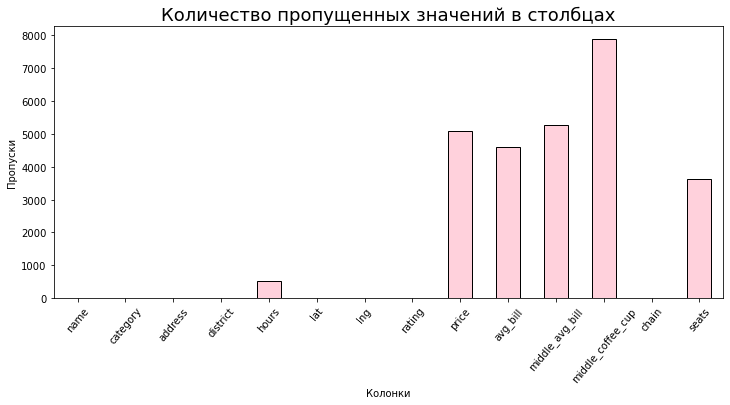

In [12]:
#график для наглядности:
data.isna().sum().plot(kind='bar', ec='black', color = '#ffd1dc', figsize = (12, 5))
plt.title('Количество пропущенных значений в столбцах', fontsize=18)
plt.xlabel('Колонки')
plt.ylabel('Пропуски')
plt.xticks(rotation = 50)
plt.show()

Количество данных с пропусками - большое. Минимальный процент - 6,38. Удалить столько мы не можем, заполнять пропуски средними или медианными значениями тоже. Заведения в одной категории в Москве могут иметь очень разный средний чек, стоимость позиций и  количество мест. Пока оставляем данные так как есть. Если пропуски помешают при дальнейших рассчетах, то решим как их заполнить или поставим заглушку.

### Добавление дополнительных столбцов

Добавим столбец с названием улиц:

In [13]:
data['street'] = data['address'].str.split(pat= ', ', expand=True)[1]

И столбец с наличием круглосуточного и ежедневного режима работы:

In [14]:
data['is_24_7'] = data['hours'].str.contains('ежедневно, круглосуточно')

Проверяем:

In [15]:
data.head(2)

,name,category,address,district,hours,lat,lng,rating,price,avg_bill,middle_avg_bill,middle_coffee_cup,chain,seats,street,is_24_7
0,wowфли,кафе,"москва, улица дыбенко, 7/1",Северный административный округ,"ежедневно, 10:00–22:00",55.878494,37.478860,5.0,NaN,NaN,NaN,NaN,0,NaN,улица дыбенко,False
1,четыре комнаты,ресторан,"москва, улица дыбенко, 36, корп. 1",Северный административный округ,"ежедневно, 10:00–22:00",55.875801,37.484479,4.5,выше среднего,Средний счёт:1500–1600 ₽,1550.0,NaN,0,4.0,улица дыбенко,False


Готово. 

Предобработка закончена, переходим к анализу данных.

## Анализ данных

### Распределение заведений по категориям

Рассмотрим распределение заведений по категориям:

,name
category,
кафе,2376
ресторан,2042
кофейня,1413
"бар,паб",764
пиццерия,633
быстрое питание,603
столовая,315
булочная,256


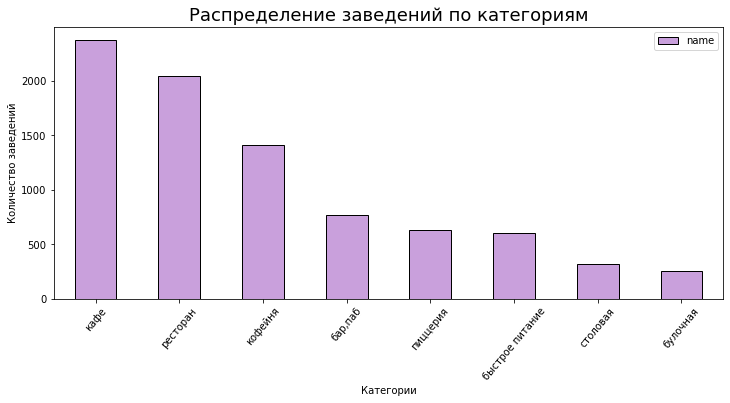

In [16]:
# группируем данные:
cafes_by_category = data.groupby('category').agg({'name':'count'}).sort_values(by='name', ascending=False)
display(cafes_by_category)

# строим график:
cafes_by_category.plot(kind='bar', color='#c9a0dc', ec='black', figsize = (12, 5))
plt.legend()
plt.title('Распределение заведений по категориям', fontsize=18)
plt.ylabel('Количество заведений')
plt.xlabel('Категории')
plt.xticks(rotation = 50);

Посмотрим распределение в долях от рынка:

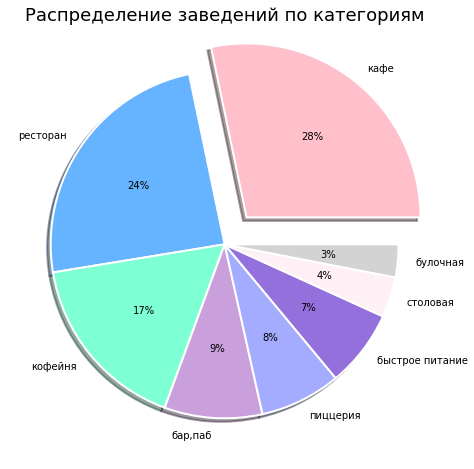

In [17]:
# строим диаграмму-пирог
data1 = data['category'].value_counts()
labels = data['category'].value_counts().index
colors = ['#FFC0CB','#66b3ff','#7FFFD4','#c9a0dc', '#a3acff', '#9370DB', '#FFF0F5', '#D3D3D3']
explode = (0.2, 0, 0, 0, 0, 0, 0, 0)
fig = plt.figure(figsize=(8,8))
plt.pie(data1, labels = labels, colors = colors, autopct='%.0f%%', wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' }, explode = explode, shadow=True)
plt.title('Распределение заведений по категориям', fontsize=18)
plt.show();

Больше всего заведений категории 'Кафе'. Далее по убыванию идут: рестораны, кофейни, пабы/бары, пицерии, бистро, столовые и на последнем месте - булочные. Численные лидеры - кафе, рестораны и кофейни, остальные категории значительно отстают по количеству. 

### Распределение посадочных мест в заведениях по категориям

Рассмотрим распределение посадочных мест в заведениях по категориям:

,seats
category,
ресторан,86.0
"бар,паб",82.0
кофейня,80.0
столовая,75.5
быстрое питание,65.0
кафе,60.0
пиццерия,55.0
булочная,50.0


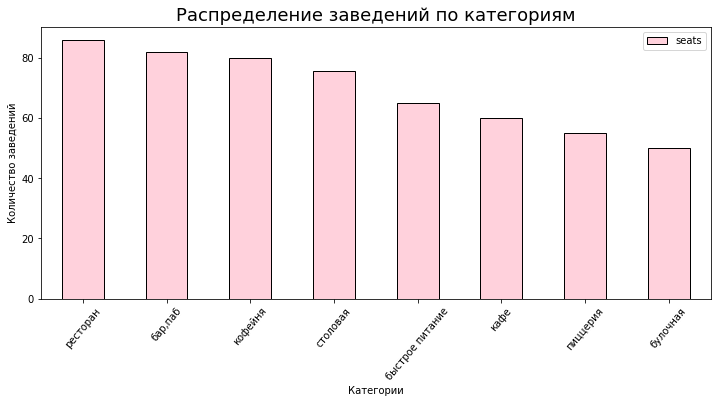

In [18]:
# группируем данные:
seats_by_category = data.groupby('category').agg({'seats':'median'}).sort_values(by='seats', ascending=False)
display(round(seats_by_category, 2))

# строим график:
seats_by_category.plot(kind='bar', color = '#ffd1dc', ec='black', figsize = (12, 5))
plt.legend()
plt.title('Распределение заведений по категориям', fontsize=18)
plt.ylabel('Количество заведений')
plt.xlabel('Категории')
plt.xticks(rotation = 50);

In [19]:
print('Максимальное количество посадочных мест:', color, data['seats'].max())

Максимальное количество посадочных мест:  1288.0


В среднем, в заведениях Москвы 50-86 посадочных мест. 
Самым большим количеством мест обладают рестораны - 86 в среднем, самым меньшим - булочные - 50 в среднем.

### Соотношение сетевых и несетевых заведений

Заменим значения 0 и 1 в столбце "chain" для удобства отображения данных:

In [20]:
data.loc[(data.chain == 1), 'chain'] = 'сетевое'
data.loc[(data.chain == 0), 'chain'] = 'не сетевое'

Рассмотрим соотношение сетевых и не сетевых заведений:

chain
не сетевое    5199
сетевое       3203
Name: name, dtype: int64

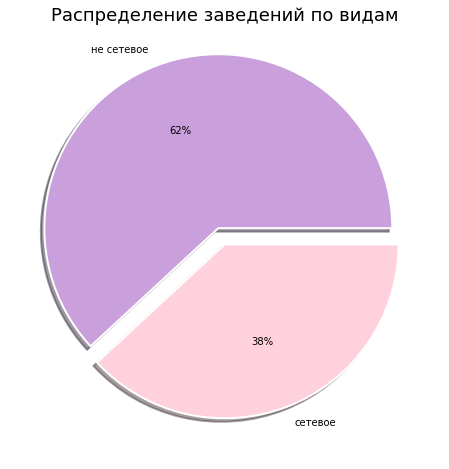

In [21]:
# группируем данные:
chain = data.groupby('chain')['name'].count()
display(chain)

# строим диаграмму-пирог
data2 = data['chain'].value_counts()
labels = data['chain'].value_counts().index
colors = ['#c9a0dc','#ffd1dc']
explode = (0.1, 0)
fig = plt.figure(figsize=(8,8))
plt.pie(data2, labels = labels, colors = colors,  autopct='%.0f%%', wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' }, explode = explode, shadow=True)
plt.title('Распределение заведений по видам', fontsize=18)
plt.show();

Не сетевых заведений значительно больше - 62% от общего числа, сетевых - 38%.

### Категории сетевых заведений

Рассмотрим категории сетевых заведений:

In [22]:
data_pivot = data.pivot_table(index='category', columns='chain', values='name', aggfunc='count')
data_pivot['total'] = data_pivot['не сетевое']+data_pivot['сетевое']
data_pivot['% сетевых'] = round((data_pivot['сетевое']/data_pivot['total'])*100)
data_pivot = data_pivot.sort_values(by='% сетевых', ascending=False)
data_pivot

chain,не сетевое,сетевое,total,% сетевых
category,,,,
булочная,99,157,256,61.0
пиццерия,303,330,633,52.0
кофейня,693,720,1413,51.0
быстрое питание,371,232,603,38.0
ресторан,1313,729,2042,36.0
кафе,1597,779,2376,33.0
столовая,227,88,315,28.0
"бар,паб",596,168,764,22.0


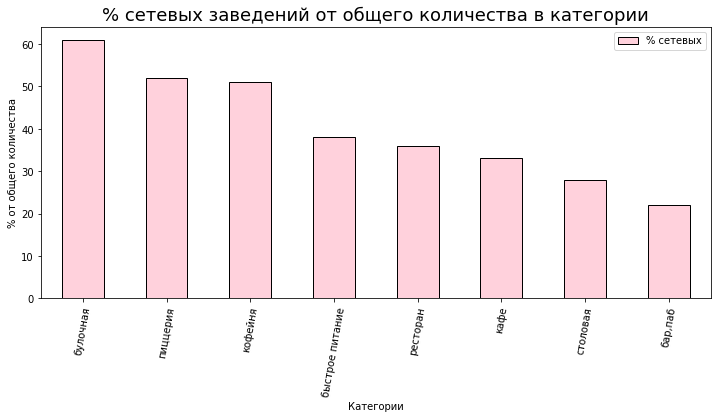

In [23]:
# строим график:
data_pivot_bar = data_pivot.drop(columns = ['не сетевое', 'сетевое', 'total'], axis = 1)
data_pivot_bar.plot(kind='bar', color='#ffd1dc', ec='black', figsize = (12, 5))
plt.legend()
plt.title('% сетевых заведений от общего количества в категории', fontsize=18)
plt.ylabel('% от общего количества')
plt.xlabel('Категории')
plt.xticks(rotation = 80);

На первых трех местах булочные, пицерии и кофейни. Меньше всего сетевых заведений в категории баров и пабов.

### Топ-15 сетевых заведений

Выделим топ-15 сетевых заведений:

,,count
name,category,
шоколадница,кофейня,119
домино'с пицца,пиццерия,76
додо пицца,пиццерия,74
one price coffee,кофейня,71
яндекс лавка,ресторан,69
cofix,кофейня,65
prime,ресторан,49
кофепорт,кофейня,42
кулинарная лавка братьев караваевых,кафе,39


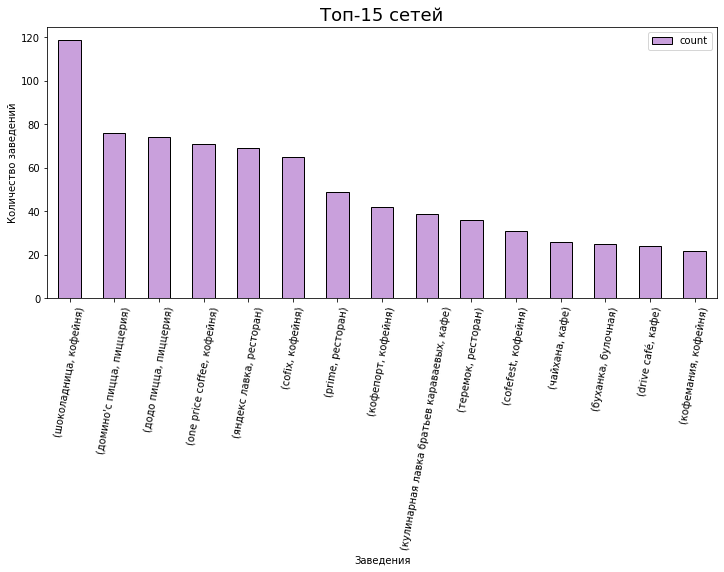

In [24]:
# группируем данные:
network_categories = data[data['chain'] == 'сетевое']
top = network_categories.groupby(['name', 'category'], \
                        as_index = True)[['address']].count().sort_values(by='address', ascending=False)
top.columns=['count']
top_15 = top.head(15)
display(top_15)

# строим график:
top_15.plot(kind='bar', color='#c9a0dc', ec='black', figsize = (12, 5))
plt.legend()
plt.title('Топ-15 сетей', fontsize=18)
plt.ylabel('Количество заведений')
plt.xlabel('Заведения')
plt.xticks(rotation = 80);

На первом месте Шоколадница, на последнем - Кофемания. 

Итого у нас в рейтинге:

- 6 кофеен;
- 3 ресторана;
- 3 кафе; 
- 2 пиццерии;
- 1 булочная.


В сфере сетевых заведений самая популярная категория - кофейни.

### Распределение заведений по округам Москвы

Рассмотрим как заведения и категории распределяются по округам Москвы:

In [ ]:
# группируем:
district = data.groupby(['district', 'category']) \
                        .agg({'name':'count'}).reset_index().sort_values(by='name', ascending=True)                                              
district = district.rename(columns={'name':'count'})

fig=px.bar(district, x='count', y = 'district', color='category', 
           color_discrete_sequence=['#D3D3D3','#F8E0EC','#7FFFD4','#66b3ff', '#a3acff', '#9370DB', '#c9a0dc', '#FFC0CB'])

# строим график:
fig.update_layout(title='Распределение заведений по округам Москвы',
                 xaxis_title='Количество объектов',
                 yaxis_title="Округи",
                 yaxis={'categoryorder':'total ascending'},
                 font=dict(size=12, color='black'))                  
fig.update_layout({
'plot_bgcolor': 'white',
'paper_bgcolor': 'white'
})
fig.show()

[![newplot.png](https://i.postimg.cc/TwqXQvMK/newplot.png)](https://postimg.cc/TLwSYSPx)

Большинство заведений расположено в Центральном округе, что логично, так как там сосредоточено много социальных, культурных  и туристических объектов, магазинов и деловых цетров. Люди приезжают в центр на работу, погулять и пройтись по магазинам. 

На последнем месте СЗАО, что неудивительно. Район отдален от центра и более 46 % его площади занимают природные ландшафты — лесопарковые массивы, водоёмы, заповедные зоны. 

Из нецентральных округов больше всего заведений находятся в САО, ЮАО и СВАО.

### Распределение средних рейтингов по категориям заведений

Посмотрим, как средний рейтинг зависит от типа заведения:

In [25]:
# группируем:
rating = data.groupby('category')['rating'].mean().reset_index().sort_values(by='rating', ascending=False)
rating = round(rating, 2)
display(rating)

,category,rating
0,"бар,паб",4.39
5,пиццерия,4.30
6,ресторан,4.29
4,кофейня,4.28
1,булочная,4.27
7,столовая,4.21
3,кафе,4.12
2,быстрое питание,4.05


In [ ]:
# строим график:
fig=px.bar(rating, x='rating', y = 'category', color='category', 
           color_discrete_sequence=['#ffd1dc'])
fig.update_layout(title='Распределение средних рейтингов по категориям',
                 xaxis_title='Рейтинг',
                 yaxis_title="Категории",
                 barmode='stack',
                 xaxis={'categoryorder':'total descending'},
                 font=dict(size=12, color='black'))
fig.update_xaxes(range=[3.5, 4.5])
fig.update_layout({
'plot_bgcolor': 'white',
'paper_bgcolor': 'white',
'showlegend': False,
})
fig.show()

fig = px.bar(x=["a", "a", "b", 3], y = [1,2,3,4])

[![newplot-1.png](https://i.postimg.cc/50kSh6MT/newplot-1.png)](https://postimg.cc/Fd3ScFzV)

Выше всего рейтинг у пабов и баров, что неудивительно, так как люди туда приходят не только за тем, чтобы поесть, но и приятно провести вечер, общаясь с другими людьми под бокал алкогольного напитка, который, как известно, увеличивает уровень лояльности потребителя. 

Ниже всего оценки у бистро. Заведения этой категории обычно характеризуются простой и доступной по цене продукцией и, часто, либо самообслуживанием, либо минимальным обслуживанием. Качество тут часто уступает цене.

В целом, различие рейтинга по категориям не слишком большое, все катеории имеют среднюю оценку выше 4 баллов. Разброс между категориями в интервале 0,4 балла.

### Фоновая картограмма со средним рейтингом заведений по округам

Посмотрим, как рапределяется рейтинг заведений по округам Москвы:

In [26]:
rating_df = data.groupby('district', as_index=False)['rating'].agg('mean').sort_values(by='rating', ascending=False)
round(rating_df, 2)

,district,rating
5,Центральный административный округ,4.38
2,Северный административный округ,4.24
4,Северо-Западный административный округ,4.21
8,Южный административный округ,4.18
1,Западный административный округ,4.18
0,Восточный административный округ,4.17
7,Юго-Западный административный округ,4.17
3,Северо-Восточный административный округ,4.15
6,Юго-Восточный административный округ,4.10


Загрузим карту Москвы и отобразим кластеры:

In [ ]:
# загружаем файл:
state_geo = 'https://code.s3.yandex.net/data-analyst/admin_level_geomap.geojson'
moscow_lat, moscow_lng = 55.751244, 37.618423

# создаём карту Москвы
m = Map(location=[moscow_lat, moscow_lng], zoom_start=10)


# создаём пустой кластер, добавляем его на карту
marker_cluster = MarkerCluster().add_to(m)

# пишем функцию, которая принимает строку датафрейма,
# создаёт маркер в текущей точке и добавляет его в кластер marker_cluster
def create_clusters(row):
    Marker(
        [row['lat'], row['lng']],
        popup=f"{row['name']} {row['rating']}",
    ).add_to(marker_cluster)

# применяем функцию create_clusters() к каждой строке датафрейма
data.apply(create_clusters, axis=1)

# выводим карту
m

[![image.png](https://i.postimg.cc/cLXhRDbd/image.png)](https://postimg.cc/Hr8bHtmN)

Добавим хороплет:

In [ ]:
# загружаем файл:
state_geo = 'https://code.s3.yandex.net/data-analyst/admin_level_geomap.geojson'
moscow_lat, moscow_lng = 55.751244, 37.618423

# создаём карту Москвы
m = Map(location=[moscow_lat, moscow_lng], zoom_start=10)

# создаём хороплет с помощью конструктора Choropleth и добавляем его на карту
Choropleth(
    geo_data=state_geo,
    data=rating_df,
    columns=['district', 'rating'],
    key_on='feature.name',
    fill_color='RdPu',
    fill_opacity=0.5,
    legend_name='Средний рейтинг заведений по районам',
).add_to(m)

# создаём пустой кластер, добавляем его на карту
marker_cluster = MarkerCluster().add_to(m)

# пишем функцию, которая принимает строку датафрейма,
# создаёт маркер в текущей точке и добавляет его в кластер marker_cluster
def create_clusters(row):
    Marker(
        [row['lat'], row['lng']],
        popup=f"{row['name']} {row['rating']}",
    ).add_to(marker_cluster)

# применяем функцию create_clusters() к каждой строке датафрейма
data.apply(create_clusters, axis=1)

# выводим карту
m

[![image.png](https://i.postimg.cc/PJVfznYm/image.png)](https://postimg.cc/n97tp5dz)

Самый высокий рейтинг у заведений в ЦАО, самый низкий в СВАО и ЮАО. При этом, все округи имеют хорошую оценку выше 4, разброс оценок всего 0,2 пункта.

### Топ-15 улиц по количеству заведений

Выделим топ-15 улиц по количеству заведений и отобразим категории:

In [ ]:
# сгруппируем данные:
top_streets = data[data['street'].isin(
    data.groupby('street')['name'].count()
    .sort_values(ascending=False).head(15).index)]

top_15_streets = top_streets.groupby(['street', 'category'], as_index=False)['name'].count()
top_15_streets.rename({'name' : 'quantity'}, axis=1, inplace=True)

# строим график:
fig = px.bar(top_15_streets, x='street', y='quantity', color='category', 
             color_discrete_sequence=['#D8BFD8', '#7FFFD4','#c9a0dc','#66b3ff', '#a3acff','#F8E0EC', '#FFC0CB', '#9370DB'])
fig.update_xaxes(tickangle=45)
fig.update_layout(title='Распределение заведений и их категорий по топ-15 улицам',
                   xaxis_title='Улица',
                   yaxis_title='Распределение',
                   xaxis={'categoryorder':'total descending'},
                   font=dict(size=12, color='black'))

fig.update_layout({
'plot_bgcolor': 'white',
'paper_bgcolor': 'white'
})
fig.show()

[![newplot-2.png](https://i.postimg.cc/3rqHBBzC/newplot-2.png)](https://postimg.cc/Wt0KpMNh)

Больше всего заведений находится на проспекте Мира, который проходит через два округа - ЦАО и СВАО. В конце рейтинга - Пятницкая улица, расположена в ЦАО.

 ### Улицы, на которых находится только один объект

Посчитаем количество улиц, на которых находится только одно заведение:                                          

In [27]:
one_cafe_streets = data.groupby('street')['name'].count() == 1
one_cafe_streets = one_cafe_streets[one_cafe_streets.values == True]
one_cafe_streets = data[data['street'].isin(one_cafe_streets.index)]
print("Улиц с одним заведением:", color, one_cafe_streets['street'].count(), back, 'штук')

display(one_cafe_streets.groupby('district')['street'].count().sort_values(ascending=False))

Улиц с одним заведением:  457  штук


district
Центральный административный округ         145
Северо-Восточный административный округ     55
Восточный административный округ            52
Северный административный округ             51
Южный административный округ                43
Юго-Восточный административный округ        39
Западный административный округ             35
Северо-Западный административный округ      19
Юго-Западный административный округ         18
Name: street, dtype: int64

In [ ]:
# строим график:
x = one_cafe_streets.groupby('district')['street'].count().sort_values(ascending=False)
y = one_cafe_streets.groupby('district')['street'].count().sort_values(ascending=False).index
plt.figure(figsize=(12,8))
sns.barplot(x=x, y=y, data=one_cafe_streets.reset_index(), palette='pastel')
plt.title('Улицы с одним заведением по округам')
plt.xlabel('Количество улиц')
plt.ylabel('Округ')
plt.show()

[![image.png](https://i.postimg.cc/m2Z8Pfmm/image.png)](https://postimg.cc/jC9z190f)

Больше всего таких улиц находится в ЦАО, меньше всего в ЮЗАО. Это логично, в центре находится много маленьких улиц и переулков.
Посмотрим, какие это категории заведений:

,count
category,
кафе,159
ресторан,93
кофейня,84
"бар,паб",39
столовая,36
быстрое питание,23
пиццерия,15
булочная,8


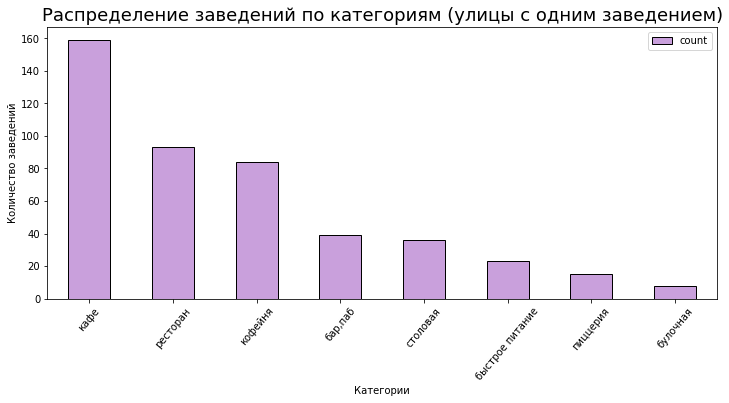

In [28]:
# группируем данные:
one_cafe_streets_category = one_cafe_streets.groupby('category').agg({'name':'count'}).sort_values(by='name', ascending=False)
one_cafe_streets_category.columns=['count']
display(one_cafe_streets_category)

# строим график:
one_cafe_streets_category.plot(kind='bar', color='#c9a0dc', ec='black', figsize = (12, 5))
plt.legend()
plt.title('Распределение заведений по категориям (улицы с одним заведением)', fontsize=18)
plt.ylabel('Количество заведений')
plt.xlabel('Категории')
plt.xticks(rotation = 50);

### Средний чек по округам (картограмма)

Посчитаем средний чек по округам:

,middle_avg_bill
district,
Западный административный округ,1000.0
Центральный административный округ,1000.0
Северо-Западный административный округ,700.0
Северный административный округ,650.0
Юго-Западный административный округ,600.0
Восточный административный округ,575.0
Северо-Восточный административный округ,500.0
Южный административный округ,500.0
Юго-Восточный административный округ,450.0


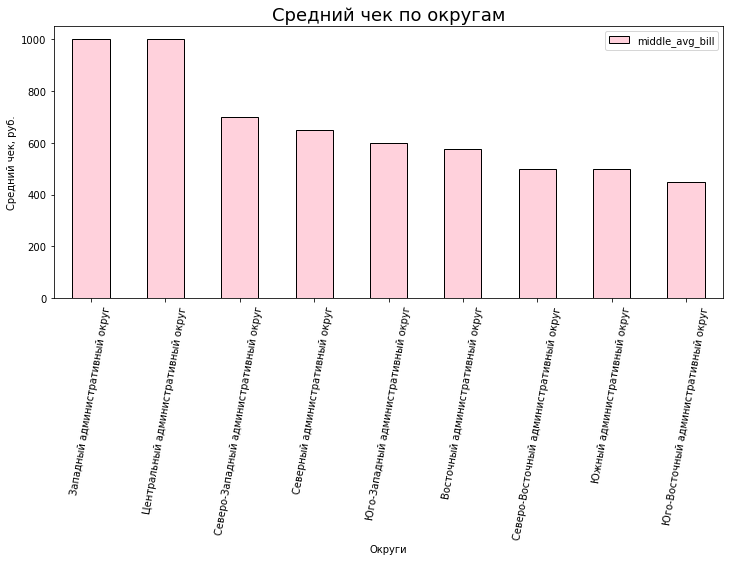

In [29]:
# группируем данные:
median_bill = data.groupby('district').agg({'middle_avg_bill':'median'}).sort_values(by='middle_avg_bill', ascending=False)
display(median_bill)

# строим график:
median_bill.plot(kind='bar', color='#ffd1dc', ec='black', figsize = (12, 5))
plt.legend()
plt.title('Средний чек по округам', fontsize=18)
plt.ylabel('Средний чек, руб.')
plt.xlabel('Округи')
plt.xticks(rotation = 80);

Больше всего чек в ЗАО, ЦАО на втором месте. Странности тут нет, ЗАО считается одним из самых престижных для проживания и одним из самых экологически чистых округов Москвы. На нем распологается в том числе Рублевское шоссе, известное место проживания людей с высоким достатком. Заведения округа характеризуются высоким уровнем цен. На последнем месте ЮВАО, район отдален от центра и, по некоторым данным, имеет не очень хорошую экологию, в округе находятся 9 промышленных зон.

Построим хороплет со средним чеком по районам:

In [ ]:
median_bill_map = median_bill.reset_index()

# создаём карту Москвы
m = Map(location=[moscow_lat, moscow_lng], zoom_start=10)

# создаём хороплет с помощью конструктора Choropleth и добавляем его на карту
Choropleth(
    geo_data=state_geo,
    data=median_bill_map,
    columns=['district', 'middle_avg_bill'],
    key_on='feature.name',
    fill_color='RdPu',
    fill_opacity=0.5,
    legend_name='Средний чек по округам Москвы',
).add_to(m)

# создаём пустой кластер, добавляем его на карту
marker_cluster = MarkerCluster().add_to(m)

# пишем функцию, которая принимает строку датафрейма,
# создаёт маркер в текущей точке и добавляет его в кластер marker_cluster
def create_clusters(row):
    Marker(
        [row['lat'], row['lng']],
        popup=f"{row['district']} {row['middle_avg_bill']}",
    ).add_to(marker_cluster)

# применяем функцию create_clusters() к каждой строке датафрейма
data.apply(create_clusters, axis=1)

# выводим карту
m

[![1.png](https://i.postimg.cc/13kGcLKh/1.png)](https://postimg.cc/SnGYm15D)

По хороплету наглядно видно, что выше всего чеки в ЦАО, ЗАО. СВАО, ЮАО и ЮВАО относятся к округам со значительно меньшим чеком, разница в медианном чеке между районами лидерами и этими районами практически в два раза. Также по карте видно, что не все нецентральные районы равны между собой, удаленность от центра сказывается на них по-разному. На это влияет престижность района. 

### Круглосуточные заведения

Посмотрим какие заведения работают круглосуточно и к каких категориям относятся:

,count
category,
кафе,267
быстрое питание,150
ресторан,135
кофейня,59
"бар,паб",52
пиццерия,31
булочная,24
столовая,12


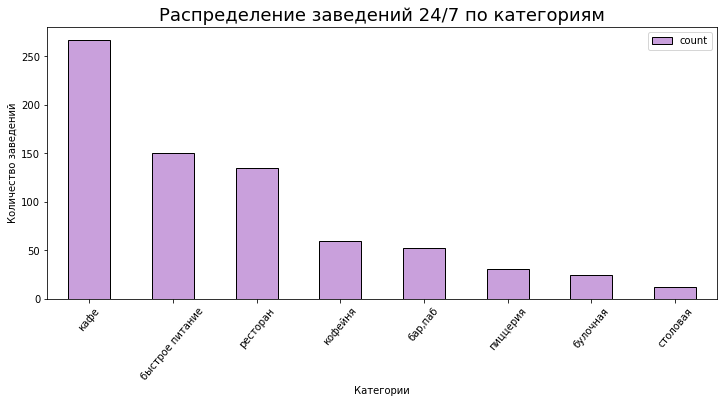

In [30]:
# фильтруем круглосуточные заведения:
data_24 = data[data['is_24_7'] == True]

# группируем данные:
data_24_category = data_24.groupby('category').agg({'name':'count'}).sort_values(by='name', ascending=False)
data_24_category.columns=['count']
display(data_24_category)

# строим график:
data_24_category.plot(kind='bar', color = '#c9a0dc', ec='black', figsize = (12, 5))
plt.legend()
plt.title('Распределение заведений 24/7 по категориям', fontsize=18)
plt.ylabel('Количество заведений')
plt.xlabel('Категории')
plt.xticks(rotation = 50);

Большая часть заведений, которыен работаю круглосуточно - это кафе, бистро и рестораны. Меньше всего круглосуточных столовых и булочных.

Посмотрим в каких районах находятся эти заведения:

In [31]:
# группируем:
district_24 = data_24.groupby(['district', 'category']) \
                        .agg({'name':'count'}).reset_index().sort_values(by='name', ascending=True)                                              
district_24 = district_24.rename(columns={'name':'count'})

district_24_count = data_24.groupby('district').agg({'name':'count'}).sort_values(by='name', ascending=False) 
display(district_24_count)

fig=px.bar(district_24, x='count', y = 'district', color='category', 
           color_discrete_sequence=['#D3D3D3','#F8E0EC','#7FFFD4','#66b3ff', '#a3acff', '#9370DB', '#c9a0dc', '#FFC0CB'])

,name
district,
Центральный административный округ,131
Восточный административный округ,97
Юго-Восточный административный округ,93
Северо-Восточный административный округ,75
Южный административный округ,75
Юго-Западный административный округ,73
Западный административный округ,72
Северный административный округ,71
Северо-Западный административный округ,43


In [ ]:
# строим график:
fig.update_layout(title='Распределение заведений по округам Москвы',
                 xaxis_title='Количество объектов',
                 yaxis_title="Округи",
                 yaxis={'categoryorder':'total ascending'},
                 font=dict(size=12, color='black'))                  
fig.update_layout({
'plot_bgcolor': 'white',
'paper_bgcolor': 'white'
})
fig.show()

[![newplot-4.png](https://i.postimg.cc/htBxX94c/newplot-4.png)](https://postimg.cc/mtmhq1F5)

Больше всего круглосуточных заведений в ЦАО и это: рестораны, кафе и кофейни, что логично, в центре жизнь бурлит 24/7, в отличии от спальных районов. Меньше всего в СЗАО.

### Вывод по главе

**В ходе данной главы мы выяснили, что**:
    
 - Больше всего заведений категории 'Кафе'. Далее по убыванию идут: рестораны, кофейни, пабы/бары, пицерии, бистро, столовые и на последнем месте - булочные. Численные лидеры - кафе, рестораны и кофейни, остальные категории значительно отстают по количеству;
 
 
 - В среднем, в заведениях Москвы 50-86 посадочных мест. 
Самым большим количеством мест обладают рестораны - 86 в среднем (встречаются банкетные заллы с более 1000 мест), самым меньшим - булочные - 50 в среднем;


 - Не сетевых заведений значительно больше, чем сетевых - 62% от общего числа, сетевых - 38%;


 - В категориях сетевых заведений на первых трех местах булочные, пицерии и кофейни. Меньше всего сетевых заведений в категории баров и пабов.
 
 
 - В топ-15 сетевых заведений на первом месте Шоколадница, на последнем - Кофемания. Всего в рейтинге: 
     - 6 кофеен;
     - 3 ресторана;
     - 3 кафе;
     - 2 пиццерии;
     - 1 булочная.
     
     
 - Большинство заведений расположено в Центральном округе, что логично, так как там сосредоточено много социальных, культурных и туристических объектов, магазинов и деловых цетров. На последнем месте СЗАО. Из нецентральных округов больше всего заведений находятся в САО, ЮАО и СВАО;


 - Выше всего рейтинг у пабов и баров. Ниже всего оценки у бистро. В целом, различие рейтинга по категориям не слишком большое, все катеории имеют среднюю оценку выше 4 баллов. Разброс между категориями в интервале 0,4 балла.
 

- Самый высокий рейтинг у заведений в ЦАО, самый низкий в СВАО и ЮАО. При этом, все округи имеют хорошую оценку выше 4, разброс оценок всего 0,2 пункта;

 - Больше всего заведений находится на проспекте Мира, который проходит через два округа - ЦАО и СВАО. В конце рейтинга - Пятницкая улица, расположена в ЦАО;
 
 
 - Больше всего круглосуточных заведений в ЦАО и это: рестораны, кафе и кофейни. Меньше всего в СЗАО.
 
 
 

Также мы построили картограммы со средним рейтингом по районам и средним чекoм по районам для наглядности.

## Детализация исследования: кофейни

**По тз к проекту**:

Основателям фонда «Shut Up and Take My Money» не даёт покоя успех сериала «Друзья». Их мечта — открыть такую же крутую и доступную, как «Central Perk», кофейню в Москве. Будем считать, что заказчики не боятся конкуренции в этой сфере, ведь кофеен в больших городах уже достаточно. Попробуйте определить, осуществима ли мечта клиентов.

Изучим кофейни поподробнее:

In [32]:
coffee = data[data['category'] =='кофейня']
print('Всего кофеен:', color, coffee['name'].count(), back, 'штук')
coffee_24 = len(coffee[coffee['is_24_7'] == 1])
print('Круглосуточных кофеен:', color, coffee_24, back, 'штук')
print('Доля круглосуточных кофеен:', color,  round(coffee_24/len(coffee)*100), back, '%')

coffee_net = len(network_categories[network_categories['category'] == 'кофейня'])
print('Сетевых кофеен:', color, coffee_net, back, 'штук')
print('Доля сетевых кофеен:', color, round((coffee_net/len(coffee))*100, 2), back, '%')

Всего кофеен:  1413  штук
Круглосуточных кофеен:  59  штук
Доля круглосуточных кофеен:  4  %
Сетевых кофеен:  720  штук
Доля сетевых кофеен:  50.96  %


Как мы видим, круглосуточных кофеен от общего числа совсем мало - 4%. Все же кофе - это тот напиток, который чаще всего употребляют в дневное время, да и работа в ночное время требует больших расходов, чем в дневное. Более половины кофеен - сетевые.

### Распределение кофеен по округам

Посмотрим как распределены кофейни по районам:

,count
district,
Центральный административный округ,428
Северный административный округ,193
Северо-Восточный административный округ,159
Западный административный округ,150
Южный административный округ,131
Восточный административный округ,105
Юго-Западный административный округ,96
Юго-Восточный административный округ,89
Северо-Западный административный округ,62


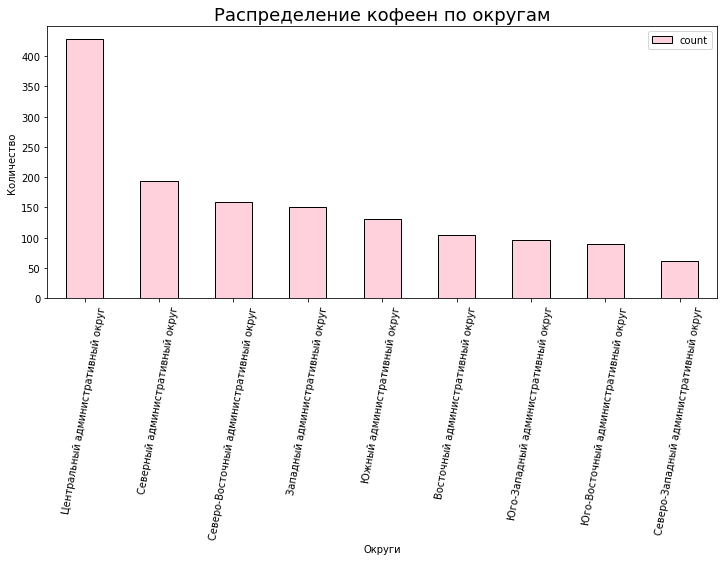

In [33]:
# группируем:
coffee_district = coffee.groupby('district') \
                        .agg({'name':'count'}).sort_values(by='name', ascending=False) 
coffee_district.columns=['count']
display(coffee_district )

# строим график:
coffee_district.plot(kind='bar', color='#ffd1dc', ec='black', figsize = (12, 5))
plt.legend()
plt.title('Распределение кофеен по округам', fontsize=18)
plt.ylabel('Количество')
plt.xlabel('Округи')
plt.xticks(rotation = 80);

Больше всего кофеен располагается в центральном округе. Меньше всего в СЗАО. Распределение аналогично общему распределению заведений. 

### Рейтинг кофеен по округам

Посмотрим, как распределяется рейтинг кофеен по округам Москвы:

In [34]:
rating_coffee = coffee.groupby('district', as_index=False)['rating'].agg('mean').sort_values(by='rating', ascending=False)
rating_coffee = round(rating_coffee, 2)
rating_coffee

,district,rating
5,Центральный административный округ,4.34
4,Северо-Западный административный округ,4.33
2,Северный административный округ,4.29
7,Юго-Западный административный округ,4.28
0,Восточный административный округ,4.28
8,Южный административный округ,4.23
6,Юго-Восточный административный округ,4.23
3,Северо-Восточный административный округ,4.22
1,Западный административный округ,4.20


Рейтинг заведений практически одинаковый во всех округах - от 4,2 до 4,35 баллов. Выше всего в ЦАО и СЗАО, ниже - В СВАО и ЗАО.

### Средняя стоимость чашки капучино

Посмотрим, как распределется средняя цена на кофе по районам:

In [35]:
middle_price = coffee.groupby('district', as_index=False)['middle_coffee_cup'].agg('median').sort_values(by='middle_coffee_cup', ascending=False)
middle_price

,district,middle_coffee_cup
7,Юго-Западный административный округ,198.0
5,Центральный административный округ,190.0
1,Западный административный округ,189.0
4,Северо-Западный административный округ,165.0
3,Северо-Восточный административный округ,162.5
2,Северный административный округ,159.0
8,Южный административный округ,150.0
6,Юго-Восточный административный округ,147.5
0,Восточный административный округ,135.0


Распределим значения на карте:

In [ ]:
# создаём карту Москвы
m = Map(location=[moscow_lat, moscow_lng], zoom_start=10)


# создаём хороплет с помощью конструктора Choropleth и добавляем его на карту
Choropleth(
    geo_data=state_geo,
    data=middle_price,
    columns=['district', 'middle_coffee_cup'],
    key_on='feature.name',
    fill_color='RdPu',
    fill_opacity=0.5,
    legend_name='Цена чашки капучино',
).add_to(m)

# создаём пустой кластер, добавляем его на карту
marker_cluster = MarkerCluster().add_to(m)

# пишем функцию, которая принимает строку датафрейма,
# создаёт маркер в текущей точке и добавляет его в кластер marker_cluster
def create_clusters(row):
    Marker(
        [row['lat'], row['lng']],
        popup=f"{row['name']} {row['middle_coffee_cup']}",
    ).add_to(marker_cluster)

# применяем функцию create_clusters() к каждой строке датафрейма
data.apply(create_clusters, axis=1)

# выводим карту
m

[![1111.png](https://i.postimg.cc/vT1nRhYw/1111.png)](https://postimg.cc/xN28MKN6)

Самый высокий ценник в ЦАО, ЗАО и ЮЗАО. Самый низкий в ВАО. На первых местах центр и престижные районы.

### Вывод по главе

В ходе данной главы мы выяснили, что:


 - Всего кофеен:  1413  штук, из них круглосуточных кофеен:  59  штук, что составляет 4% от общего количества. Более половины кофеен - сетевые;
 - Больше всего кофеен располагается в Центральном округе. Меньше всего в СЗАО. Распределение аналогично общему распределению заведений;
 - Рейтинг заведений практически одинаковый во всех округах - от 4,2 до 4,35 баллов. Выше всего в ЦАО и СЗАО, ниже - В СВАО и ЗАО;
 - Самый высокий ценник в ЦАО, ЗАО и ЮЗАО - 189-198 рублей/чашка. Самый низкий в ВАО - 135 рублей/чашка. На первых местах центр и престижные районы.

## Итоговый вывод и рекомендации

**В ходе выполнения данного проекта были проделаны следующие шаги**:

- Загружены и предобработаны данные;


- Изучено распределение заведений по категориям. Больше всего заведений категории 'кафе'. Далее по убыванию идут: рестораны, кофейни, пабы/бары, пицерии, бистро, столовые и на последнем месте - булочные. Численные лидеры - кафе, рестораны и кофейни, остальные категории значительно отстают по количеству;


- Изучено распределение посадочных мест по категориям заведений. В среднем, в заведениях Москвы 50-86 посадочных мест. Самым большим количеством мест обладают рестораны - 86, самым меньшим - булочные - 50;


- Рассмотрено соотношение сетевых и несетевых заведений. Не сетевых заведений значительно больше, чем сетевых - 62% от общего числа, сетевых - 38%;


 - В категориях сетевых заведений на первых трех местах булочные, пицерии и кофейни. Меньше всего сетевых заведений в категории баров и пабов.;


- Выделен топ-15 сетевых заведений. На первом месте Шоколадница, на последнем - Кофемания. Всего в рейтинге:
     - 6 кофеен;
     - 3 ресторана;
     - 3 кафе;
     - 2 пиццерии;
     - 1 булочная.
  
  
- Изучено распределение заведений по округам Москвы.Большинство заведений расположено в Центральном округе, что логично, так как там сосредоточено много социальных, культурных и туристических объектов, магазинов и деловых центров. На последнем месте СЗАО. Из нецентральных округов больше всего заведений находятся в САО, ЮАО и СВАО;


 - Проиллюстрирован рейтинг заведений по категориям (Выше всего рейтинг у пабов и баров. Ниже всего оценки у бистро. В целом, различие рейтинга по категориям не слишком большое, все катеории имеют среднюю оценку выше 4 баллов. Разброс между категориями в интервале 0,4 балла) и округам (Самый высокий рейтинг у заведений в ЦАО, самый низкий в СВАО и ЮАО;


 - Выявлен топ-15 улиц по количеству заведений: больше всего заведений на проспекте Мира, который проходит через два округа - ЦАО и СВАО. В конце рейтинга - Пятницкая улица, расположена в ЦАО;
 
 
 - Рассмотрено распределение круглосуточных заведений по округам и категориям: больше всего круглосуточных заведений в ЦАО и это: рестораны, кафе и кофейни. Меньше всего в СЗАО.
 
 
- Рассмотрен средний чек по округам Москвы: больше всего чек в ЗАО, ЦАО на втором месте. Странности тут нет, ЗАО считается одним из самых престижных для проживания и одним из самых экологически чистых округов Москвы. На нем распологается в том числе Рублевское шоссе, известное место проживания людей с высоким достатком. Заведения округа характеризуются высоким уровнем цен. На последнем месте ЮВАО, район отдален от центра и, по некоторым данным, имеет не очень хорошую экологию, в округе находятся 9 промышленных зон.


- Рассмотрели категорию **кофеен** отдельно и выяснили, что:
     - Всего кофеен: 1413 штук, из них круглосуточных кофеен: 59 штук, что составляет 4% от общего количества. Более половины кофеен - сетевые;
     - Больше всего кофеен располагается в центральном округе. Меньше всего в СЗАО. Распределение аналогично общему распределению заведений;
     - Рейтинг заведений практически одинаковый во всех округах - от 4,2 до 4,35 баллов. Выше всего в ЦАО и СЗАО, ниже - В СВАО и ЗАО;
     - Самый высокий ценник в ЦАО, ЗАО и ЮЗАО - 189-198 рублей/чашка. Самый низкий в ВАО - 135 рублей/чашка. На первых местах центр и престижные районы.

<div style="border: solid #c9a0dc 2px; padding: 20px; font-size: 16px; border-radius: 3px;">


**Рекомендации по открытию кофейни**:
    

Так как основатели не боятся конкуренции и им не дает покоя успех кофейни «Central Perk» из сериала "Друзья" (уютная кофейня для встреч друзей, расположенная в центральной части Нью Йорка, в "тусовочной" части Манхеттена у Централ Парка), а также они хотят, чтобы кофейня была доступная, то отталкиваемся мы от следующих **факторов**:

 - Большая проходимость, в том числе покупателями с разным уровнем достатка;
 - Удобное расположение, локация в одном из самых посещаемых мест города, как жителями, так и туристами столицы;
 - Доступные цены на уровне средних цен района.
 
Исходя из имеющихся факторов, я бы предложила рассматривать ЦАО. Несмотря на высокую конкуренцию, расположение и проходимость самые лучшие в городе. Тем более, что основатели хотят открыть знаковое заведение, а не просто типовой кофепоинт. Спальные районы в этом значительно уступают центру. Несмотря на то, что в этих районах (на первый взгляд) меньше конкуренция из-за меньшего количества кофеен, на практике это часто оказывается обоснованным. Например, особенностями района (как в СЗАО, где почти половина территории - это лесопарковые массивы и водоемы), или привычками людей (люди чаще покупают кофе там, где работают, ходят по магазинам или гуляют в выходные, и обычно это не спальные районы, да и встречаться с друзьями из других районов удобнее всего в центре). 


Лучше всего выбрать улицы в самом центре, где сосредоточено много культурных объектов, достопримечательностей, магазинов и  прогулочных улиц, которые являются местами притяжения людей не только всего города, но и всей страны. Желательно в пределах Садового кольца. Например, Никольскую улицу, которая к тому же является пешеходной. Или район парка "Зарядье" со стороны Китай-города (по аналогии с Централ Парком). Это один из самых посещаемых районов Москвы.


Искать улицу с одним заведением также необязательно. В центральном районе достаточная проходимость, чтобы обеспечить посетителями большое количество заведений, да и одно заведение на улице еще не признак удачного места с низкой конкуренцией. Скорее это будет значить, что эта улица не очень подходит для открытия большего количества заведений, например, в силу непопулярности прогулок на этой улице у потенциальных покупателей.


По стоимости кофе необходимо ориентироваться на среднюю цену по району - 190 рублей за чашку капучино.


Для более конкретных рекомендаций не достаточно информации. Нужно знать какой у основателей бюджет, и какая конкретно в их представлении дожна быть кофейня (от ее ЦА до меню, интерьера и дополнительных функций), и отталкиваясь от этого строить стратегию поиска конкретного места, перебирая улицы и сдаваемые объекты, анализируя каждый подробнее.

</div>


Презентация: 👉 [тут](https://disk.yandex.ru/i/k5BtQlCgkH3Fww)